In [16]:
import matplotlib.pyplot as plt
import numpy as np

import torch

# DeepMoD stuff
from deepymod import DeepMoD
from deepymod.model.func_approx import NN, Siren
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic

from reaction_diffusion import OneDimensionalRDEquations, random_periodic

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)


if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'


%load_ext autoreload
%autoreload 2

In [17]:
def random_initialiser(shape):
    return(
        np.random.normal(loc=0, scale=0.05, size=shape),
        np.random.normal(loc=0, scale=0.05, size=shape)
    )

In [18]:
def laplacian2D(a, dx):
    return (
        - 4 * a
        + np.roll(a,1,axis=0) 
        + np.roll(a,-1,axis=0)
        + np.roll(a,+1,axis=1)
        + np.roll(a,-1,axis=1)
    ) / (dx ** 2)

In [49]:
class TwoDimensionalRDEquations():
    def __init__(self, Da, Db, Ra, Rb,
                 initialiser=random_initialiser,
                 width=1000, height=1000,
                 dx=1, dt=0.1, steps=1):
        
        self.Da = Da
        self.Db = Db
        self.Ra = Ra
        self.Rb = Rb
        self.Ya = []
        self.Yb = []
        
        self.initialiser = initialiser
        self.width = width
        self.height = height
        self.shape = (width, height)
        self.dx = dx
        self.dt = dt
        self.steps = steps
        
    def initialise(self):
        self.t = 0
        self.a, self.b = self.initialiser(self.shape)
    
    def make_grid(self):
        self.x_arr = np.arange(0,self.width,self.dx)
        self.y_arr = np.arange(0,self.width,self.dx)
        self.t_arr = self.dt*np.arange(0,self.steps)
        self.x_grid, self.y_grid, self.t_grid = np.meshgrid(self.x_arr, self.y_arr, self.t_arr, indexing='ij')
        
        
    def update(self):
        for _ in range(self.steps):
            self.t += self.dt
            self._update()

    def _update(self):
        
        # unpack so we don't have to keep writing "self"
        a,b,Da,Db,Ra,Rb,dt,dx = (
            self.a, self.b,
            self.Da, self.Db,
            self.Ra, self.Rb,
            self.dt, self.dx
        )
        
        La = laplacian2D(a, dx)
        Lb = laplacian2D(b, dx)
        
        delta_a = dt * (Da * La + Ra(a,b))
        delta_b = dt * (Db * Lb + Rb(a,b))
        
        self.a += delta_a
        self.b += delta_b
                
        self.Ya.append(np.array(self.a))
        self.Yb.append(np.array(self.b))

In [143]:
Da, Db, alpha, beta = 5, 10, -0.02, 5

def Ra(a,b): return a - a ** 3 - b + alpha
def Rb(a,b): return (a - b) * beta

width = 100
dx = 1
dt = 0.001

In [144]:
solution = TwoDimensionalRDEquations(
    Da, Db, Ra, Rb, 
    width=width, height=width, 
    dx=dx, dt=dt, steps=2000
)

In [145]:
solution.initialise()
solution.update()
solution.make_grid()

In [146]:
solution.x_grid.shape

(100, 100, 2000)

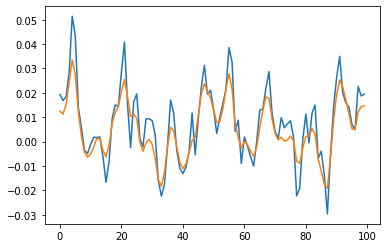

In [147]:
plt.plot(solution.Ya[100][10])
plt.plot(solution.Ya[190][10])

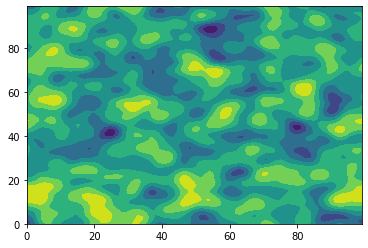

In [149]:
plt.contourf(solution.Yb[500])

In [150]:
start=500

In [151]:
x_grid, y_grid, t_grid = solution.x_grid[:,:,start:]/np.max(solution.x_grid), solution.y_grid[:,:,start:]/np.max(solution.y_grid),solution.t_grid[:,:,start:]/np.max(solution.t_grid)

In [152]:
y1, y2 = np.array(solution.Ya[start:]).T.flatten(), np.array(solution.Yb[start:]).T.flatten()

In [153]:
X = np.transpose((t_grid.flatten(), x_grid.flatten(), y_grid.flatten()))
y = np.transpose((y1/np.max(y1),  y2/np.max(y2)))

In [154]:
X.shape

(15000000, 3)

In [155]:
y.shape

(15000000, 2)

In [62]:
number_of_samples = 10000
idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32).to(device)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32).to(device)

In [63]:
from torch.autograd import grad
from itertools import combinations
from functools import reduce
from typing import Tuple
from deepymod.utils.types import TensorList
from deepymod import Library

class Library_custom(Library):
    """[summary]

    Args:
        Library ([type]): [description]
    """
    def __init__(self) -> None:
        super().__init__()

    def library(self, input: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[TensorList, TensorList]:
    
        prediction, data = input
        samples = prediction.shape[0]
        poly_list = []
        deriv_list = []
        time_deriv_list = []
        
        
        # Construct the theta matrix
        C = torch.ones_like(prediction[:,0]).view(samples, -1)
        u = prediction[:,0].view(samples, -1)
        v = prediction[:,1].view(samples, -1)
        
        du = grad(u, data, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = du[:, 1:2]
        u_y = du[:, 2:3]
        dux = grad(u_x, data, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = dux[:, 1:2]
        duy = grad(u_y, data, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_yy = dux[:, 1:2]
        
        dv = grad(v, data, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        v_x = dv[:, 1:2]
        v_y = dv[:, 2:3]
        dvx = grad(v_x, data, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        v_xx = dvx[:, 1:2]
        dvy = grad(v_y, data, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        v_yy = dvy[:, 2:3]
        
        theta = torch.cat((C, u, u*u, u*u*u, v, v*v, v*v*v, u_x, u_y, u_xx, u_yy, v_x, v_y, v_xx, v_yy),dim=1)
        
        
        
        # Construct a list of time_derivatives 
        time_deriv_list = []
        for output in torch.arange(prediction.shape[1]):
            dy = grad(prediction[:,output], data, grad_outputs=torch.ones_like(prediction[:,output]), create_graph=True)[0]
            time_deriv = dy[:, 0:1]
            time_deriv_list.append(time_deriv)
        
        return time_deriv_list, [theta,theta]

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [64]:
network = Siren(3, [50, 50, 50,50], 2)

Configuration of the library function: We select athe library with a 2D spatial input. Note that that the max differential order has been pre-determined here out of convinience. So, for poly_order 1 the library contains the following 12 terms:
* [$1, u_x, u_{xx}, u_{xxx}, u, u u_{x}, u u_{xx}, u u_{xxx}, u^2, u^2 u_{x}, u^2 u_{xx}, u^2 u_{xxx}$]

In [65]:
library = Library_custom() 

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.  

In [66]:
estimator = Threshold(0.1) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=10, delta=1e-5) 

Configuration of the sparsity estimator 

In [67]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

Now we instantiate the model and select the optimizer 

In [68]:
model = DeepMoD(network, library, estimator, constraint).to(device)

In [69]:
# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=2.5e-4) 

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data:
* The directory where the tensorboard file is written (log_dir)
* The ratio of train/test set used (split)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

In [70]:
train(model, X_train, y_train, optimizer,sparsity_scheduler, log_dir='runs/Reaction/', split=0.8, max_iterations=100000, delta=2.5e-7, patience=10) 

    75  MSE: 3.39e-02  Reg: 5.03e-04  L1: 3.51e+00 

KeyboardInterrupt: 